In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

In [3]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10, mnist
import tensorflow.keras.backend as K
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
import time
# import plotly
# import plotly.express as px

In [4]:
# input image dimensions
img_rows, img_cols = 32, 32
img_chn = 1

# Load CIFAR-10 dataset-
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
if img_chn == 1:
    x_train = x_train.mean(axis=3)                                                                                    
    x_test = x_test.mean(axis=3)           
    
input_shape = (img_rows, img_cols, img_chn)

# Convert datasets to floating point types-
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize the training and testing datasets-
if img_chn == 1:
    x_train = x_train.reshape((x_train.shape[0], \
                                         img_rows, img_rows, img_chn)) / 255.
    x_test = x_test.reshape((x_test.shape[0], \
                                      img_rows, img_rows, img_chn)) / 255.
else:
    x_train = x_train/255.
    x_test = x_test/255.


print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {x_train.shape} & X_test.shape: {x_test.shape}")

load_outlier_detector = True

latent_dim = 2
epochs =20


Dimensions of training and testing sets are:
X_train.shape: (50000, 32, 32, 1) & X_test.shape: (10000, 32, 32, 1)


In [5]:
def batch_creation(X_data, batch_size):
    end = X_data.shape[0]-1
    start = 0
    batch_split_X = list()
    while start < end:
        img_slice = np.array(X_data[start:start+batch_size])
        batch_split_X.append(img_slice)
        start = start + batch_size
    return np.array(batch_split_X, dtype=object)
    
train_dataset = batch_creation(x_train, 32)
test_dataset = batch_creation(x_test, 32)
train_dataset.shape

(1563,)

In [6]:
def plot_latent_images(model, n, epoch, im_size=32, save=True, first_epoch=False, f_ep_count=0):
    
    # Create image matrix 
    image_width = im_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width, img_chn))

    # Create list of values which are evenly spaced wrt probability mass

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    
    # For each point on the grid in the latent space, decode and

    # copy the image into the image array
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (im_size, im_size, img_chn))
            image[i * im_size: (i + 1) * im_size,
                  j * im_size: (j + 1) * im_size] = digit.numpy()
    

    # Plot the image array
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')


    # Potentially save, with different formatting if within first epoch
#     if save and first_epoch:
#         plt.savefig('tf_grid_at_epoch_{:04d}.{:04d}.png'.format(epoch, f_ep_count))
#     elif save:
#         plt.savefig('tf_grid_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [7]:

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, logvar, z = model.encode(x)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
latent_dim = 2
# input image dimensions
img_rows, img_cols = 32, 32
img_chn = 1

In [9]:
class Encoder(tf.keras.Model):
    def __init__(self,hp):
        super(Encoder, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),\
        #activation function
        activation='relu',input_shape=(32,32,1))
        self.conv2 = tf.keras.layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),\
        #activation function
        activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),\
        #activation function
        activation='relu')
        self.flat1 = tf.keras.layers.Flatten()
        self.dens1 = tf.keras.layers.Dense(2)
        self.dens2 = tf.keras.layers.Dense(2)
        self.sampl = Sampling()
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flat1(x)
        mu = self.dens1(x)
        va = self.dens2(x)
        z = self.sampl([mu,va])
        
        return mu, va, z
    
    def model(self):
        x = Input(shape=(32,32,1))
        return Model(inputs=[x], outputs=self.call(x))
    
class Decoder(tf.keras.Model):
    def __init__(self, ):
        super(Decoder, self).__init__()
        self.dens3 = tf.keras.layers.Dense(units=4*4*128, activation=tf.nn.relu, input_shape=(2,))
        self.resh1 = tf.keras.layers.Reshape(target_shape=(4, 4, 128))
        self.deco1 = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same',  activation=tf.nn.relu)
        self.deco2 = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same',  activation=tf.nn.relu)
        # No activation
        self.deco3 = tf.keras.layers.Conv2DTranspose(img_chn, 3, strides=2, padding='same')
        
    def call(self, inp):
        x = self.dens3(inp)
        x = self.resh1(x)
        x = self.deco1(x)
        x = self.deco2(x)
        x = self.deco3(x)
        return x
    
    def model(self):
        x = Input(shape=(2))
        return Model(inputs=[x], outputs=self.call(x))

In [10]:
class AE(tf.keras.Model):
    def __init__(self,hp):
        super(AE, self).__init__()
        self.encoder = Encoder(hp)
        self.decoder = Decoder()

    def call(self, inp):
        mu, va, z = self.encoder(inp)
        out_decoder = self.decoder(z)
        return z, out_decoder 
    
    def model(self):
        x = Input(shape=(img_rows,img_cols,img_chn))
        return Model(inputs=[x], outputs=self.call(x))
    
    def encode(self, img):
        return self.encoder(img)
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    @tf.function
    def sample(self, z=None):
        if z is None:
            z = tf.random.normal(shape=(100, latent_dim))
        return self.decode(z, apply_sigmoid=True)
    
#     @tf.function
#     def train_step(self, x, optimizer):
#         """Executes one training step and returns the loss.

#         This function computes the loss and gradients, and uses the latter to
#         update the model's parameters.
#         """
#         with tf.GradientTape() as tape:
#             loss = compute_loss(model, x)
#         gradients = tape.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [11]:
class CVAE_Hypermodel(keras_tuner.HyperModel):
    def build(self, hp):
        return AE(hp)
    
    @tf.function
    def sample(self, z=None):
        if z is None:
            z = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(z, apply_sigmoid=True)

    def fit(self, hp, model, x, y, validation_data, callbacks=None, **kwargs):
        # Convert the datasets to tf.data.Dataset.
        batch_size = hp.Int("batch_size", 32, 128, step=32, default=64)
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(
            batch_size)
        validation_data = tf.data.Dataset.from_tensor_slices(validation_data).batch(
            batch_size
        )


#         loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        loss_fn = compute_loss

        # The metric to track validation loss.
        epoch_loss_metric = keras.metrics.Mean()
        
        @tf.function
        def run_train_step(x, optimizer):
            """Executes one training step and returns the loss.

            This function computes the loss and gradients, and uses the latter to
            update the model's parameters.
            """
            with tf.GradientTape() as tape:
                loss = loss_fn(model, x)
                if model.losses:
                    loss += tf.math.add_n(model.losses) 
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
#         # Function to run the validation step.
# #         @tf.function
# #         def run_val_step(images, labels):
# #             logits = model(images)
# #             loss = loss_fn(labels, logits)
# #             # Update the metric.
# #             epoch_loss_metric.update_state(loss)

        # Assign the model to the callbacks.
        for callback in callbacks:
            callback.model = model

        # Record the best validation loss value
        best_epoch_loss = float("inf")

        # Define the optimizer.
        optimizer = keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log", default=1e-3)
        )
        
        # The custom training and validation loop.
        for epoch in range(1, epochs + 1):
            start_time = time.time()
            for idx, train_x in enumerate(train_dataset):
                run_train_step(train_x, optimizer)
                if epoch == 1 and idx % 75 == 0:
                    plot_latent_images(model, 10, epoch=epoch, first_epoch=True, f_ep_count=idx)          
            end_time = time.time()
            loss = tf.keras.metrics.Mean()  # chooses MEAN as the reduction strategy between epochs

            for test_x in test_dataset:
                loss(compute_loss(model, test_x))  # mean of the compute_loss
            elbo = -loss.result()
            #display.clear_output(wait=False)
            print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
                .format(epoch, elbo, end_time - start_time))
            if epoch != 1:
                plot_latent_images(model, 20, epoch=epoch)

            # Calling the callbacks after epoch.
            epoch_loss = float(elbo)
            for callback in callbacks:
                # The "my_metric" is the objective passed to the tuner.
                callback.on_epoch_end(epoch, logs={"my_metric": epoch_loss})
            epoch_loss_metric.reset_states()

            print(f"Epoch loss: {epoch_loss}")
            best_epoch_loss = min(best_epoch_loss, epoch_loss)

        # Return the evaluation metric value.
        return best_epoch_loss

            
        


In [12]:
h_model = CVAE_Hypermodel() 

In [13]:
hp = keras_tuner.HyperParameters()
model = h_model.build(hp)
model.model().summary()
print("***********************************\n********************************\n))")
model.encoder.model().summary()
print("***********************************\n********************************\n))")
model.decoder.model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Encoder)           ((None, 2),               105348    
                              (None, 2),                         
                              (None, 2))                         
                                                                 
 decoder (Decoder)           (None, 32, 32, 1)         98689     
                                                                 
Total params: 204,037
Trainable params: 204,037
Non-trainable params: 0
_________________________________________________________________
***********************************
********************************
))
Model: "model_1"
__________________________________________________________________________________________________

In [15]:
tuner = keras_tuner.RandomSearch(
    objective=keras_tuner.Objective("my_metric", "min"),
    max_trials=2,
    hypermodel=CVAE_Hypermodel(),
    directory="results",
    project_name="custom_training",
    overwrite=True,
)

In [16]:
import time
tuner.search(x=x_train, y=y_train, validation_data=(x_test, y_test))

Trial 2 Complete [00h 06m 05s]
my_metric: -659.1856689453125

Best my_metric So Far: -659.1856689453125
Total elapsed time: 00h 10m 56s
INFO:tensorflow:Oracle triggered exit


In [19]:
tuner.results_summary()

Results summary
Results in results/custom_training
Showing 10 best trials
Trial summary
Hyperparameters:
conv_1_filter: 48
conv_1_kernel: 5
conv_2_filter: 48
conv_2_kernel: 3
conv_3_filter: 112
conv_3_kernel: 3
batch_size: 64
learning_rate: 0.00015978705252452907
Score: -659.1856689453125
Trial summary
Hyperparameters:
conv_1_filter: 112
conv_1_kernel: 5
conv_2_filter: 64
conv_2_kernel: 3
conv_3_filter: 96
conv_3_kernel: 3
batch_size: 64
learning_rate: 0.001
Score: -657.7086791992188


In [20]:
best_hps = tuner.get_best_hyperparameters()[0]
len(tuner.get_best_hyperparameters())
print(best_hps.values)

{'conv_1_filter': 48, 'conv_1_kernel': 5, 'conv_2_filter': 48, 'conv_2_kernel': 3, 'conv_3_filter': 112, 'conv_3_kernel': 3, 'batch_size': 64, 'learning_rate': 0.00015978705252452907}


In [21]:
tuner.get_best_hyperparameters()[0].values

{'conv_1_filter': 48,
 'conv_1_kernel': 5,
 'conv_2_filter': 48,
 'conv_2_kernel': 3,
 'conv_3_filter': 112,
 'conv_3_kernel': 3,
 'batch_size': 64,
 'learning_rate': 0.00015978705252452907}

In [22]:
loss = tf.keras.metrics.Mean()

In [23]:
best_model = tuner.get_best_models()[0]

In [24]:
best_model.build(input_shape=(None,32,32,1))

In [25]:
best_model.encoder.model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 48)   1248        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 26, 26, 48)   20784       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 24, 24, 112)  48496       ['conv2d_1[0][0]']               
                                                                                              

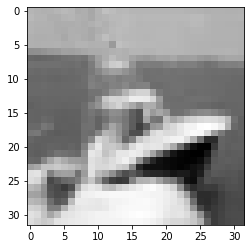

In [26]:
%matplotlib inline
i=8
plt.imshow(x_train[i], cmap='gray')

In [27]:
a, b, c = best_model.encode(x_train[i].reshape(1,32,32,1))

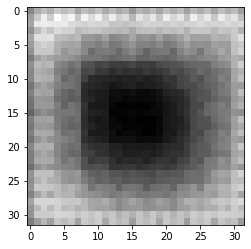

In [29]:
%matplotlib inline
d = best_model.decode(c)
plt.imshow(d[0], cmap='gray')